In [32]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt, log
import warnings
from joblib import dump, load

In [281]:
train = pd.read_pickle("/Users/liyannie/Desktop/Sp_2019_courses/DS_Indus/project/liyan/train.pkl")
test = pd.read_pickle("/Users/liyannie/Desktop/Sp_2019_courses/DS_Indus/project/liyan/test.pkl")

In [282]:
train.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'travel_time', 'mo', 'temp',
       'visib', 'wdsp', 'gust', 'max', 'min', 'prcp', 'fog', 'rain_drizzle',
       'snow_ice_pellets', 'haver_dist', 'man_dist', 'hour_of_day',
       'day_of_week', 'work', 'weekday', 'pickup_cluster', 'dropoff_cluster',
       'num_rides_pcluster', 'num_rides_dcluster', 'num_rides_ccluster'],
      dtype='object')

# Load saved models

In [122]:
# do not take lat/lon
ridge_grid1 = load('ridge_grid1.joblib') # ridge + OHE
ridge_grid2 = load('ridge_grid2.joblib') # ridge + OHE + target + interaction
ridge_grid3 = load('ridge_grid3.joblib') # Ridge + OHE + target + Power + Scaling
lasso_grid1 = load('lasso_grid1.joblib') # lasso + OHE + target + power + scaling

# take all inputs
xg_grid1 = load('xg_grid1.joblib') # xg + OHE
xg_grid2 = load('xg_grid2.joblib') # xg + oHE + target
rf_grid1 = load('rf_grid1.joblib') # RF + OHE + target

In [35]:
X_train = train.loc[:, train.columns != 'travel_time']
y_train = train['travel_time']
X_test = test.loc[:, train.columns != 'travel_time']
y_test = test['travel_time']

# Define functions
- scoring functions. Only random forest has RMSLE.
- coef visualization

In [80]:
def scores1(model, X_test):
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print('Test RMSE = {}'.format(rmse))
    print('Test R2 = {}'.format(r2))
    
    return rmse, r2

In [81]:
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    terms_to_sum = [(log(y_pred[i] + 1) - log(y_true[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y_true))) ** 0.5

In [64]:
def scores2(model, X_test):
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    rmsle1 = rmsle(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print('Test RMSE = {}'.format(rmse))
    print('Test RMSLE = {}'.format(rmsle1))
    print('Test R2 = {}'.format(r2))
    
    return rmse, rmsle1, r2

In [244]:
def plot_coef(coef, feature_names, title, top_features=10):
    coef1 = coef.ravel()
    top_positive_coefficients = np.argsort(coef1)[-top_features:]
    top_negative_coefficients = np.argsort(coef1)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    plt.figure(figsize=(10, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]] 
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 2 * top_features), 
               feature_names[top_coefficients], 
               rotation=60, ha ='right')
    plt.subplots_adjust(bottom=0.1)
    plt.title(title)
    plt.show()

In [255]:
def plot_feat_imp(coef, feature_names, title, top_features=10):
    coef1 = coef.ravel()
    top_coefficients = np.argsort(coef1)[-top_features:]
    plt.figure(figsize=(10, 5))
    plt.bar(np.arange(top_features), coef[top_coefficients], color = 'pink')
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, top_features), 
               feature_names[top_coefficients], 
               rotation=60, ha ='right')
    plt.subplots_adjust(bottom=0.1)
    plt.title(title)
    plt.show()

In [68]:
def cv_result1(model, param_name):
    warnings.filterwarnings('ignore')
    result = pd.DataFrame(model.cv_results_)[[param_name, 
                                              'mean_test_neg_mean_squared_error', 
                                               'mean_test_r2']]
    result['RMSE'] = result['mean_test_neg_mean_squared_error'].apply(lambda x: sqrt(-x))
    
    return result

In [89]:
def plot_param_r2(model, param_name, title):
    result1 = cv_result1(model, param_name)
    x = result1[param_name]
    y = result1['mean_test_r2']
    plt.plot(x, y)
    plt.xlabel(param_name)
    plt.ylabel('R2')
    plt.title(title)
    plt.show()

In [91]:
def plot_param_rmse(model, param_name, title):
    result1 = cv_result1(model, param_name)
    x = result1[param_name]
    y = result1['RMSE']
    plt.plot(x, y)
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.title(title)
    plt.show()

# Linear models

In [36]:
# linear model
X_test_lin = X_test.drop(labels = ['pickup_longitude', 'pickup_latitude', 
                                     'dropoff_longitude', 'dropoff_latitude'], 
                           axis = 1)

## 1. Ridge + OHE

In [82]:
scores1(ridge_grid1, X_test_lin)

Test RMSE = 458.7190404350547
Test R2 = 0.5551475959853511


(458.7190404350547, 0.5551475959853511)

In [85]:
cv_result1(ridge_grid1, 'param_ridge__alpha')

,param_ridge__alpha,mean_test_neg_mean_squared_error,mean_test_r2,RMSE
0,0.001,-120673.940163,0.667107,347.381548
1,0.00774264,-120668.334166,0.667123,347.373479
2,0.0599484,-120626.069251,0.667249,347.312639
3,0.464159,-120346.209882,0.668082,346.909513
4,3.59381,-118984.323682,0.672145,344.941044
5,27.8256,-115409.613970,0.682875,339.719905
6,215.443,-114796.944014,0.685004,338.816977
7,1668.1,-118467.284651,0.674408,344.190768
8,12915.5,-125498.874498,0.654685,354.258203
9,100000,-131344.426444,0.639252,362.414716


In [71]:
#pd.DataFrame(ridge_grid1.cv_results_).columns

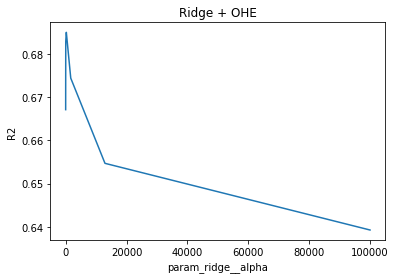

In [90]:
plot_param_r2(ridge_grid1, 'param_ridge__alpha', title = 'Ridge + OHE')

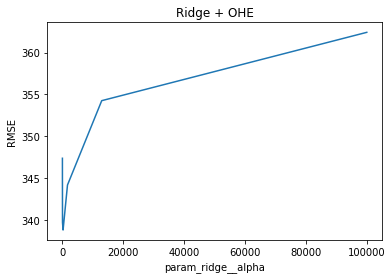

In [92]:
plot_param_rmse(ridge_grid1, 'param_ridge__alpha', title = 'Ridge + OHE')

In [13]:
# ohe features names ['mo', 'fog', 'rain_drizzle', 'snow_ice_pellets', 'day_of_week', 'work', 'weekday',
           #'pickup_cluster', 'dropoff_cluster', 'hour_of_day']]
cat_cols = ridge_grid1.best_estimator_.steps[0][1].named_transformers_['onehotencoder'].get_feature_names()

# when using remainder='passthrough', the numerical columns will be appended at the end (right side)
num_cols = np.asarray(['passenger_count', 'temp', 'visib', 'wdsp', 'gust', 'max', 'min',
                       'prcp','haver_dist', 'man_dist', 'num_rides_pcluster','num_rides_dcluster', 
                       'num_rides_ccluster'])

# all feature names: order of features is the same as the order they appear in columntransformer
ridge1_featnames = np.concatenate((cat_cols, num_cols), axis = None)

# all coefficients
ridge1_coef = ridge_grid1.best_estimator_.steps[1][1].coef_

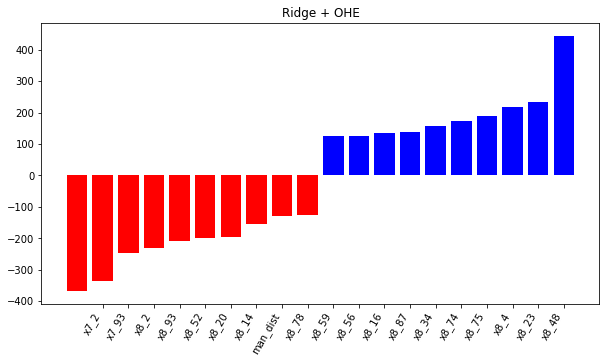

In [245]:
plot_coef(ridge1_coef, ridge1_featnames, "Ridge + OHE", top_features=10)

- haversine dist
- manhattan dist
- dropoff cluster
- pickup cluster
- hour of day

## 2. Ridge + OHE + target + interaction (best for interpretability)
- (best among linear models. Linear models are good for interpretability, use this one if want to explain to people how the prediction works)

In [123]:
scores1(ridge_grid2, X_test_lin)

Test RMSE = 446.8839259870943
Test R2 = 0.5778061768538747


(446.8839259870943, 0.5778061768538747)

In [124]:
cv_result1(ridge_grid2, 'param_ridge__alpha')

,param_ridge__alpha,mean_test_neg_mean_squared_error,mean_test_r2,RMSE
0,0.001,-121161.029377,0.669885,348.081929
1,0.00774264,-121159.262048,0.669889,348.079390
2,0.0599484,-121145.150226,0.669924,348.059119
3,0.464159,-121036.655221,0.670189,347.903227
4,3.59381,-120243.208333,0.672129,346.761025
5,27.8256,-116037.989281,0.682421,340.643493
6,215.443,-109400.858110,0.698757,330.758005
7,1668.1,-108392.720412,0.701532,329.230497
8,12915.5,-107218.233233,0.705185,327.441954
9,100000,-107022.572891,0.705981,327.143047


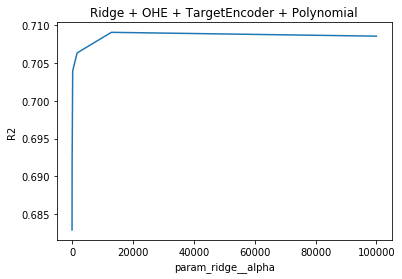

In [120]:
plot_param_r2(ridge_grid2, 'param_ridge__alpha', title = 'Ridge + OHE + TargetEncoder + Polynomial')

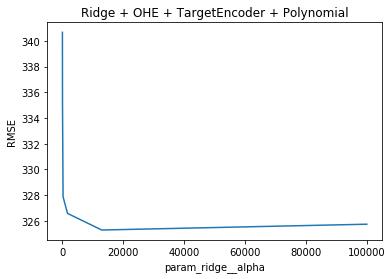

In [121]:
plot_param_rmse(ridge_grid2, 'param_ridge__alpha', title = 'Ridge + OHE + TargetEncoder + Polynomial')

### coefficients too complicated to figure out, since I put everything in a pipeline and it added interaction terms

## 3. Ridge + OHE + target + Power + Scaling

In [125]:
scores1(ridge_grid3, X_test_lin)

Test RMSE = 487.77785247039014
Test R2 = 0.4970016479268543


(487.77785247039014, 0.4970016479268543)

In [126]:
cv_result1(ridge_grid3, 'param_ridge__alpha')

,param_ridge__alpha,mean_test_neg_mean_squared_error,mean_test_r2,RMSE
0,0.001,-158777.354005,0.563186,398.468762
1,0.00774264,-158777.350685,0.563186,398.468757
2,0.0599484,-158777.325023,0.563186,398.468725
3,0.464159,-158777.129080,0.563186,398.468479
4,3.59381,-158775.773964,0.563191,398.466779
5,27.8256,-158773.888558,0.563203,398.464413
6,215.443,-158989.425913,0.562654,398.734781
7,1668.1,-160182.798775,0.559572,400.228433
8,12915.5,-162912.950276,0.552904,403.624764
9,100000,-200364.709866,0.450815,447.621168


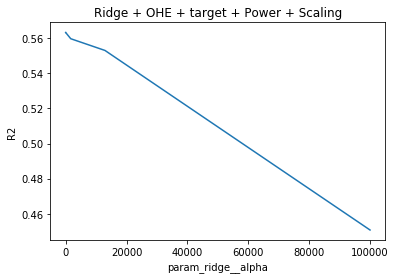

In [129]:
plot_param_r2(ridge_grid3, 'param_ridge__alpha', title = 'Ridge + OHE + target + Power + Scaling')

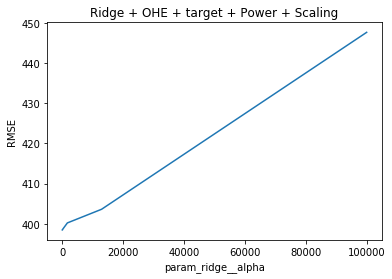

In [130]:
plot_param_rmse(ridge_grid3, 'param_ridge__alpha', title = 'Ridge + OHE + target + Power + Scaling')

- OHE = ['mo', 'fog', 'rain_drizzle', 'snow_ice_pellets', 'day_of_week', 'work', 'weekday']
- target = ['pickup_cluster', 'dropoff_cluster', 'hour_of_day']
- num = ['passenger_count', 'temp', 'visib', 'wdsp', 'gust', 'max', 'min','prcp', 'haver_dist','man_dist','num_rides_pcluster','num_rides_dcluster', 'num_rides_ccluster']

In [181]:
ohe_cols = ridge_grid3.best_estimator_.steps[0][1].named_transformers_['onehotencoder'].get_feature_names()
target_cols = ridge_grid3.best_estimator_.steps[0][1].named_transformers_['targetencoder'].get_feature_names()
num_cols = ridge_grid3.best_estimator_.steps[0][1].transformers_[2][2]
ridge3_featnames = np.concatenate((ohe_cols, target_cols, num_cols), axis = None)
ridge3_coef = ridge_grid3.best_estimator_.steps[1][1].coef_

In [183]:
ohe_cols

array(['x0_01', 'x0_02', 'x0_03', 'x0_04', 'x0_05', 'x1_0', 'x1_1',
       'x2_0', 'x2_1', 'x3_0', 'x3_1', 'x4_0', 'x4_4', 'x4_5', 'x4_6',
       'x5_0', 'x5_1', 'x6_0', 'x6_1'], dtype=object)

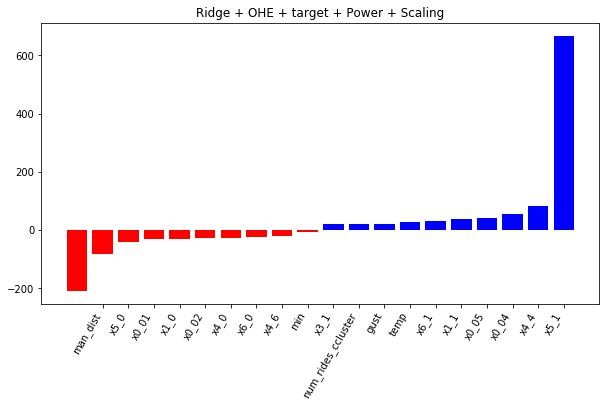

In [246]:
plot_coef(ridge3_coef, ridge3_featnames, "Ridge + OHE + target + Power + Scaling", top_features=10)

- haversince distance
- mo
- fog
- day_of_week
- work
- Manhattan distance

# 4. lasso + OHE + target + power + scaling

In [184]:
scores1(lasso_grid1, X_test_lin)

Test RMSE = 492.72360083614706
Test R2 = 0.48674978795785906


(492.72360083614706, 0.48674978795785906)

In [185]:
cv_result1(lasso_grid1, 'param_lasso__alpha')

,param_lasso__alpha,mean_test_neg_mean_squared_error,mean_test_r2,RMSE
0,0.001,-158776.878847,0.563187,398.468165
1,0.00774264,-158773.603925,0.563198,398.464056
2,0.0599484,-158731.735357,0.563324,398.411515
3,0.464159,-158559.968385,0.563885,398.195892
4,3.59381,-159519.732475,0.561719,399.399214
5,27.8256,-162581.508054,0.553798,403.213973
6,215.443,-207418.558196,0.431612,455.432276
7,1668.1,-363455.708787,-0.000784,602.872879
8,12915.5,-363455.708787,-0.000784,602.872879
9,100000,-363455.708787,-0.000784,602.872879


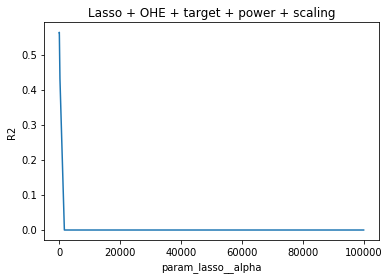

In [186]:
plot_param_r2(lasso_grid1, 'param_lasso__alpha', title = 'Lasso + OHE + target + power + scaling')

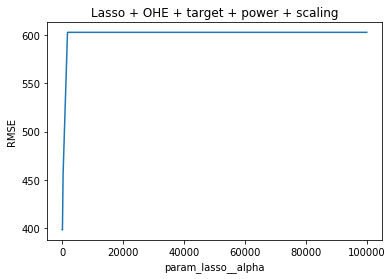

In [187]:
plot_param_rmse(lasso_grid1, 'param_lasso__alpha', title = 'Lasso + OHE + target + power + scaling')

- OHE = ['mo', 'fog', 'rain_drizzle', 'snow_ice_pellets', 'day_of_week', 'work', 'weekday']
- target = ['pickup_cluster', 'dropoff_cluster', 'hour_of_day']
- num = ['passenger_count', 'temp', 'visib', 'wdsp', 'gust', 'max', 'min','prcp', 'haver_dist','man_dist','num_rides_pcluster','num_rides_dcluster', 'num_rides_ccluster']

In [188]:
ohe_cols = lasso_grid1.best_estimator_.steps[0][1].named_transformers_['onehotencoder'].get_feature_names()
target_cols = lasso_grid1.best_estimator_.steps[0][1].named_transformers_['targetencoder'].get_feature_names()
num_cols = lasso_grid1.best_estimator_.steps[0][1].transformers_[2][2]
lasso1_featnames = np.concatenate((ohe_cols, target_cols, num_cols), axis = None)
lasso1_coef = lasso_grid1.best_estimator_.steps[1][1].coef_

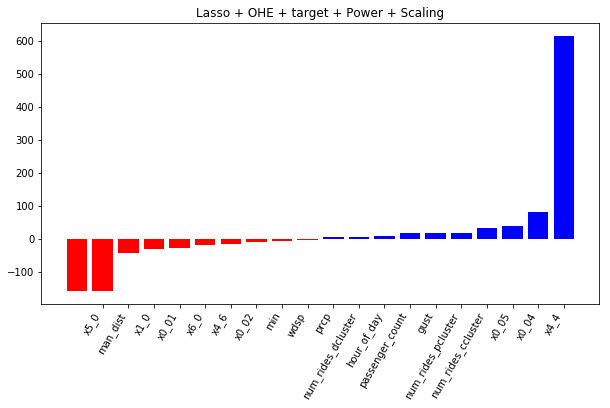

In [247]:
plot_coef(lasso1_coef, lasso1_featnames, "Lasso + OHE + target + Power + Scaling", top_features=10)

- haversine dist
- mo
- day_of_week
- work
- manhattan dist
- fog

# 5. xg + OHE

In [215]:
scores1(xg_grid1, X_test)

Test RMSE = 392.5658900136989
Test R2 = 0.6742026632194551


(392.5658900136989, 0.6742026632194551)

In [216]:
warnings.filterwarnings('ignore')

xg_result1 = pd.DataFrame(xg_grid1.cv_results_)[['param_xgbregressor__max_depth', 
                                                'param_xgbregressor__min_child_weight', 
                                                'mean_test_neg_mean_squared_error',
                                                'mean_test_r2']]
xg_result1

,param_xgbregressor__max_depth,param_xgbregressor__min_child_weight,mean_test_neg_mean_squared_error,mean_test_r2
0,10,10,-107570.437095,0.759445
1,10,20,-107485.455627,0.760027
2,10,30,-107787.477562,0.759484
3,15,10,-108679.835036,0.756963
4,15,20,-107469.899916,0.759830
5,15,30,-106615.323719,0.761689
6,20,10,-109788.689964,0.754586
7,20,20,-108476.000347,0.757508
8,20,30,-107283.524675,0.760330


- ohe features names ['mo', 'fog', 'rain_drizzle', 'snow_ice_pellets', 'day_of_week', 'work', 'weekday', #'pickup_cluster', 'dropoff_cluster', 'hour_of_day']]

In [224]:
cat_cols = xg_grid1.best_estimator_.steps[0][1].named_transformers_['onehotencoder'].get_feature_names()
num_cols = np.asarray(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'temp', 'visib', 'wdsp', 'gust', 'max', 'min',
                       'prcp','haver_dist', 'man_dist', 'num_rides_pcluster','num_rides_dcluster', 
                       'num_rides_ccluster'])
xg1_featnames = np.concatenate((cat_cols, num_cols), axis = None)
xg1_coef = xg_grid1.best_estimator_.steps[1][1].feature_importances_

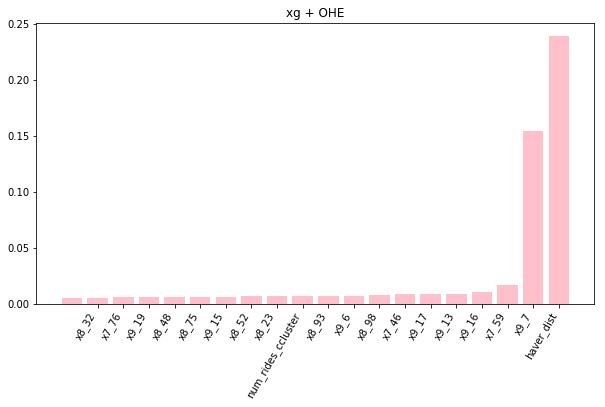

In [257]:
plot_feat_imp(xg1_coef, xg1_featnames, "xg + OHE", top_features=20)

- haversince dist
- hour_of_day
- pickup cluster
- dropoff cluster
- num_rides_ccluster

# 6. xg + OHE + target (best  for prediction)

In [261]:
scores1(xg_grid2, X_test)

Test RMSE = 374.41420867682706
Test R2 = 0.7036349062850897


(374.41420867682706, 0.7036349062850897)

In [262]:
warnings.filterwarnings('ignore')

xg_result2 = pd.DataFrame(xg_grid2.cv_results_)[['param_xgbregressor__max_depth', 
                                                'param_xgbregressor__min_child_weight', 
                                                'mean_test_neg_mean_squared_error',
                                                'mean_test_r2']]
xg_result2

,param_xgbregressor__max_depth,param_xgbregressor__min_child_weight,mean_test_neg_mean_squared_error,mean_test_r2
0,15,10,-106362.352181,0.762192
1,15,20,-104077.776087,0.767168
2,15,30,-102992.388587,0.769598
3,10,10,-103924.321197,0.767564
4,10,20,-103218.794775,0.769149
5,10,30,-102368.980159,0.771106
6,25,10,-108091.970081,0.758372
7,25,20,-105046.798502,0.764987
8,25,30,-102952.495024,0.769606


- ohe = ['mo', 'fog', 'rain_drizzle', 'snow_ice_pellets', 'day_of_week', 'work', 'weekday']

In [263]:
X_test.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'mo', 'temp', 'visib', 'wdsp',
       'gust', 'max', 'min', 'prcp', 'fog', 'rain_drizzle', 'snow_ice_pellets',
       'haver_dist', 'man_dist', 'hour_of_day', 'day_of_week', 'work',
       'weekday', 'pickup_cluster', 'dropoff_cluster', 'num_rides_pcluster',
       'num_rides_dcluster', 'num_rides_ccluster'],
      dtype='object')

In [266]:
ohe_cols = xg_grid2.best_estimator_.steps[0][1].named_transformers_['onehotencoder'].get_feature_names()
tar_cols = xg_grid2.best_estimator_.steps[0][1].named_transformers_['targetencoder'].get_feature_names()
num_cols = np.asarray(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'temp', 'visib', 'wdsp', 'gust', 'max', 'min',
                       'prcp','haver_dist', 'man_dist', 'num_rides_pcluster','num_rides_dcluster', 
                       'num_rides_ccluster'])
xg2_featnames = np.concatenate((ohe_cols, tar_cols, num_cols), axis = None)
xg2_coef = xg_grid2.best_estimator_.steps[1][1].feature_importances_

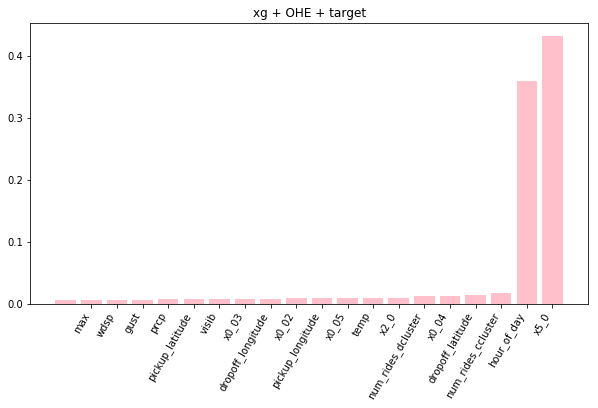

In [270]:
plot_feat_imp(xg2_coef, xg2_featnames, "xg + OHE + target", top_features=20)

- work
- hour_of_day
- num_rides_ccluster
- dropoff latitude
- mo
- num_rides_dcluster

# 7. RF + OHE + target

In [273]:
scores2(rf_grid1, X_test)

Test RMSE = 380.816943385318
Test RMSLE = 0.4617778183147868
Test R2 = 0.6934121546215966


(380.816943385318, 0.4617778183147868, 0.6934121546215966)

In [277]:
warnings.filterwarnings('ignore')

rf_result1 = pd.DataFrame(rf_grid1.cv_results_)[['param_randomforestregressor__max_features', 
                                                'param_randomforestregressor__n_estimators', 
                                                'mean_test_neg_mean_squared_error', 
                                                'mean_test_neg_mean_squared_log_error',
                                                'mean_test_r2']]
rf_result1

,param_randomforestregressor__max_features,param_randomforestregressor__n_estimators,mean_test_neg_mean_squared_error,mean_test_neg_mean_squared_log_error,mean_test_r2
0,0.7,100,-108780.106365,-0.158181,0.756900
1,0.7,200,-108311.575508,-0.157426,0.757906
2,0.7,300,-108613.121181,-0.158415,0.757266
3,0.8,100,-109996.965066,-0.158432,0.753968
4,0.8,200,-110027.729652,-0.161279,0.754268
5,0.8,300,-109243.902910,-0.158631,0.755779
6,0.9,100,-111002.409712,-0.160654,0.751899
7,0.9,200,-110416.212409,-0.159462,0.753179
8,0.9,300,-109712.374797,-0.158679,0.754674


- ohe = ['mo', 'fog', 'rain_drizzle', 'snow_ice_pellets', 'day_of_week', 'work', 'weekday']

In [278]:
ohe_cols = rf_grid1.best_estimator_.steps[0][1].named_transformers_['onehotencoder'].get_feature_names()
tar_cols = rf_grid1.best_estimator_.steps[0][1].named_transformers_['targetencoder'].get_feature_names()
num_cols = np.asarray(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'temp', 'visib', 'wdsp', 'gust', 'max', 'min',
                       'prcp','haver_dist', 'man_dist', 'num_rides_pcluster','num_rides_dcluster', 
                       'num_rides_ccluster'])
rf1_featnames = np.concatenate((ohe_cols, tar_cols, num_cols), axis = None)
rf1_coef = rf_grid1.best_estimator_.steps[1][1].feature_importances_

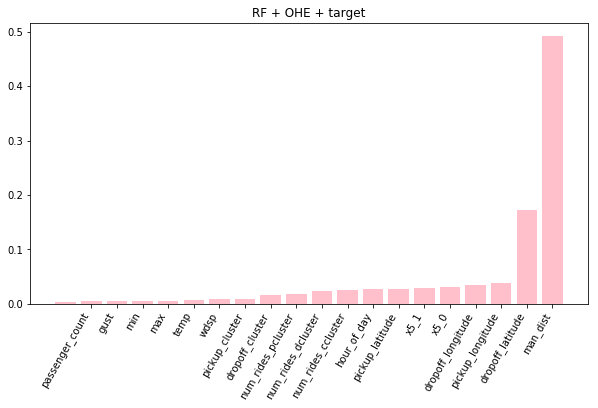

In [279]:
plot_feat_imp(rf1_coef, rf1_featnames, "RF + OHE + target", top_features=20)

- manhattan dist
- dropoff latitude
- pickup longitude
- dropoff longitude
- work
- hour of day

# plot
- feature importance
- relationship between cv score and parameters
- comparison between models in different folds

In [280]:
X_train.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'mo', 'temp', 'visib', 'wdsp',
       'gust', 'max', 'min', 'prcp', 'fog', 'rain_drizzle', 'snow_ice_pellets',
       'haver_dist', 'man_dist', 'hour_of_day', 'day_of_week', 'work',
       'weekday', 'pickup_cluster', 'dropoff_cluster', 'num_rides_pcluster',
       'num_rides_dcluster', 'num_rides_ccluster'],
      dtype='object')